<a href="https://colab.research.google.com/github/talhaanwarch/Epilepsy_classification/blob/master/Epilepsyv1_gaussian_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://zenodo.org/record/1252141

In [1]:
!pip install git+https://github.com/forrestbao/pyeeg.git
!pip install git+https://github.com/talhaanwarch/entropy.git


  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-kw4ohcbr
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-kw4ohcbr
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28122 sha256=7b9c3d17ee71b5e81b8d0731515ccc8b689d49662e0d211b40cb364d06fbede0
  Stored in directory: /tmp/pip-ephem-wheel-cache-i30qtb6j/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg
  Cloning https://github.com/talhaanwarch/entropy.git to /tmp/pip-req-build-9ahq0qvd
  Running command git clone -q https://github.com/talhaanwarch/entropy.git /tmp/pip-req-build-9ahq0qvd
  Created wheel for entropy: filename=entropy-0.1.1-cp36-none-any.whl size=15448 sha256=1729339208691fc6b8badc86aa5179ed0c0038e44572f233ea64006cff621332
  Stored in directory: /tmp/pip-ephem-wheel-cache-6y4bh7vu/wheels/79/43/63/3fa9c8c5f03fe3a78d71c1aeedca9577f2f32fb2156ff9ecf8
Successfully built entropy


In [2]:
!wget https://zenodo.org/record/1252141/files/EEGs_Guinea-Bissau.zip

--2020-10-19 09:59:30--  https://zenodo.org/record/1252141/files/EEGs_Guinea-Bissau.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153973086 (147M) [application/octet-stream]
Saving to: ‘EEGs_Guinea-Bissau.zip’

EEGs_Guinea-Bissau. 100%[===================>] 146.84M  15.0MB/s    in 10s     

2020-10-19 09:59:41 (14.5 MB/s) - ‘EEGs_Guinea-Bissau.zip’ saved [153973086/153973086]



In [3]:
from zipfile import ZipFile 
data = ZipFile('EEGs_Guinea-Bissau.zip')
data.extractall()

In [4]:
import pandas as pd

In [5]:
meta=pd.read_csv('https://zenodo.org/record/1252141/files/metadata_guineabissau.csv')

In [6]:
meta.head()

subject.id     Group  ... recordedPeriod        startTime
0           1  Epilepsy  ...            301  27/5/2020 14:33
1           2   Control  ...            309  26/5/2020 22:44
2           3  Epilepsy  ...            309  27/5/2020 14:26
3           4  Epilepsy  ...            299  27/5/2020 15:23
4           5   Control  ...            302  23/5/2020 19:09

[5 rows x 6 columns]

In [7]:
EP_sub=meta['subject.id'][meta['Group']=='Epilepsy']
CT_sub=meta['subject.id'][meta['Group']=='Control']

In [8]:
Epilepsy=[]
for i in EP_sub:
  Epilepsy.append(pd.read_csv('EEGs_Guinea-Bissau/signal-{}.csv.gz'.format(i), compression='gzip')) 

In [9]:
Control=[]
for i in CT_sub:
  Control.append(pd.read_csv('EEGs_Guinea-Bissau/signal-{}.csv.gz'.format(i), compression='gzip')) 

In [10]:
Epilepsy[0].head()

Unnamed: 0          AF3          AF4  ...  CQ_T8  CQ_F8  CQ_DRL
0           1  4426.153846  3994.871795  ...      4      4       4
1           2  4420.512821  3986.666667  ...      4      4       4
2           3  4413.846154  3986.153846  ...      4      4       4
3           4  4407.692308  3984.615385  ...      4      4       4
4           5  4407.179487  3978.974359  ...      4      4       4

[5 rows x 36 columns]

In [11]:
channels=Epilepsy[0].columns[1:15].tolist()


In [12]:
from scipy import signal
import numpy as np
nyq = 0.5 * 128
l=0.3
low = l / nyq
high = 30 / nyq
b, a = signal.butter(3, [low,high], 'band')

In [13]:
EP_data=[]
for EP in Epilepsy:
  data=EP.iloc[:,1:15].values
  mu, sigma = np.mean(data), np.std(data)
  noise = np.random.normal(mu, sigma, data.shape)*0.2
  data=data+noise
  data=signal.filtfilt(b, a, data.T)
  EP_data.append(data.T)


In [14]:
CT_data=[]
for CT in Control:
  data=CT.iloc[:,1:15].values
  
  mu, sigma = np.mean(data), np.std(data)
  noise = np.random.normal(mu, sigma, data.shape)*0.2
  data=data+noise
  data=signal.filtfilt(b, a, data.T)
  CT_data.append(data.T)


In [15]:
import numpy as np
X1=np.concatenate(CT_data)
X2=np.concatenate(EP_data)
X=np.concatenate((X1,X2))
X.shape

(3850368, 14)

In [16]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA().fit(X)


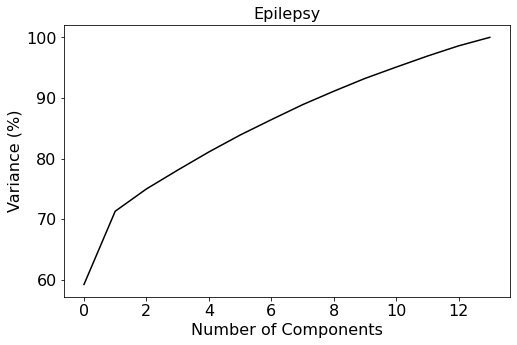

In [17]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 16})

#plt.axhline(0.95)
#plt.axvline(9)
#Plotting the Cumulative Summation of the Explained Variance
plt.plot(np.cumsum(pca.explained_variance_ratio_*100)[0:25],color='k')
plt.xlabel('Number of Components',fontsize=16)
plt.ylabel('Variance (%)',fontsize=16) #for each component
plt.title('Epilepsy',fontsize=16)
plt.show()

In [18]:
df1 = pd.DataFrame.from_records(X)
df1.columns=channels
df1.shape

(3850368, 14)

In [19]:
ch=11
X_1=df1.var()
idx=X_1.sort_values()[-ch::].index

print(idx)
ch=len(idx)

Index(['O1', 'F7', 'F3', 'AF3', 'O2', 'F4', 'FC6', 'T8', 'AF4', 'F8', 'P8'], dtype='object')


In [20]:

indx=[]
for i in idx:
  indx.append(channels.index(i))
indx=np.array(indx)

In [21]:
def reshape(data):   
    shape=data.ravel().shape[0]
    s=shape%(14*1000)
    if s!=0:
        d=data.ravel()[s//2:-s//2].reshape(-1,1000,14)[:,:,indx]
        #return np.swapaxes(d,1,2)   
        return d
    else: 
        d1=data.reshape(-1,1000,14)[:,:,indx]
        #return np.swapaxes(d1,1,2)   
        return d1

In [22]:

EP_reshaped=[]
for i in EP_data:
    EP_reshaped.append(reshape(i))
    
    
CT_reshaped=[]
for i in CT_data:
    CT_reshaped.append(reshape(i))

In [23]:
EP_reshaped[0].shape

(38, 1000, 11)

In [24]:
from scipy import stats
import pyeeg
from entropy import *
def mean(data):
    return np.mean(data,axis=0)
    
def std(data):
    return np.std(data,axis=0)

def ptp(data):
    return np.ptp(data,axis=0)

def var(data):
        return np.var(data,axis=0)

def minim(data):
      return np.min(data,axis=0)


def maxim(data):
      return np.max(data,axis=0)

def argminim(data):
      return np.argmin(data,axis=0)


def argmaxim(data):
      return np.argmax(data,axis=0)

def mean_square(data):
      return np.mean(data**2,axis=0)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)


def skewness(data):
    return stats.skew(data,axis=0)

def kurtosis(data):
    return stats.kurtosis(data,axis=0)

def zero_crossing(data):
    return np.argmax(np.diff(np.sign(data),axis=0),axis=0)

def app_epy(data):
    result=[]
    for i in data.T:
        result.append(app_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)

def perm_epy(data):
    result=[]
    for i in data.T:
        result.append(perm_entropy(i, order=3, normalize=True))
    return np.array(result)

def svd_epy(data):
    result=[]
    for i in data.T:
        result.append(svd_entropy(i, order=3, delay=1, normalize=True))
    return np.array(result)

def spectral_epy(data):
    result=[]
    for i in data.T:
        result.append(spectral_entropy(i, 100, method='welch', normalize=True))
    return np.array(result)

def sample_epy(data):
    result=[]
    for i in data.T:
        result.append(sample_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)


def katz(data):
    result=[]
    for i in data.T:
        result.append(katz_fd(i))
    return np.array(result)

def higuchi(data):
    result=[]
    for i in data.T:
        result.append(higuchi_fd(i))
    return np.array(result)


def petrosian(data):
    result=[]
    for i in data.T:
        result.append(petrosian_fd(i))
    return np.array(result)

def autogressiveModelParameters(data):
    feature = []
    for i in data.T:
        coeff, sig = alg.AR_est_YW(i, order=5)
        feature.append(np.mean(coeff))
    return np.array(feature)

def teager(x):
    for i in range(len(x)-1):
        return x[i]**2 - (x[i-1]*x[i+1])


def lziv_complex(data):
    result=[]
    for i in data.T:
        result.append(lziv_complexity(i))
    return np.array(result)

        
def hjorth_mobility(data):
    return np.divide(np.std(np.diff(data,axis=0),axis=0),np.std(data,axis=0))

def hjorth_complexity(data):
    return np.divide(hjorth_mobility(np.diff(data,axis=0)),  hjorth_mobility(data))      




def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),argminim(data),argmaxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data),zero_crossing(data),
                          app_epy(data),perm_epy(data),svd_epy(data),spectral_epy(data),sample_epy(data),
                          katz(data),higuchi(data),petrosian(data),teager(data),lziv_complex(data),
                          hjorth_mobility(data),hjorth_complexity(data)),axis=0)


In [25]:
features1=[]
for f in CT_reshaped:
    feature=[]
    for i in f:
        feature.append(concatenate_features(i))
    features1.append(np.mean(np.array(feature),axis=0))
    

In [26]:

features2=[]
for f in EP_reshaped:
    feature=[]
    for i in f:
        feature.append(concatenate_features(i))
    features2.append(np.mean(np.array(feature),axis=0))

In [27]:
x1=np.array(features1)        
x2=np.array(features2)      

X=np.concatenate((x1,x2),axis=0)
y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))


In [28]:
X.shape,y.shape

((97, 286), (97,))

#import libraries

In [29]:
from scipy import stats
import pyeeg
from entropy import *
import pywt
#from nitime import algorithms as alg
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
#import nolds
np.warnings.filterwarnings('ignore')

# Classification

In [30]:
#%% split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42,stratify=y)

In [31]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [32]:

clf=SVC(kernel='rbf')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test,y_pred))
print('accuracy is ',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.57      0.59        14
         1.0       0.65      0.69      0.67        16

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30

accuracy is  0.6333333333333333


#feature

In [33]:
feature_list=['mean','std','ptp','var','minim','maxim','argmin','argmax','mean_square','rms','abs_diffs_signal','skewness','kurtosis','zero_crossing',
'app_epy','perm_epy','svd_epy','spectral_epy','sample_epy','katz','higuchi','petrosian','teager','lziv_complex',
'hjorth_mobility','hjorth_complexity']

In [34]:
feature=X.copy()
label=y.copy()
from sklearn.preprocessing import scale,maxabs_scale
feature=scale(feature)

In [35]:
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y):
    Cs = [ 0.1, 1, 10,15,20,25,30,40,50,60,70,100,120]
    gammas = [0.0001,0.0005,0.001,0.005,0.008, 0.01, 0.1,0.3,0.5, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=10)
    grid_search.fit(X, y)
    print(grid_search.best_params_)
    return grid_search.best_score_


svc_param_selection(feature,label)


{'C': 25, 'gamma': 0.0001}


0.6888888888888889

In [36]:
clf = SVC(kernel="rbf", C=25,gamma=0.0001, probability=True)
acc = cross_val_score(clf,feature,label,cv=10)
precision = cross_val_score(clf,feature,label,cv=10,scoring='precision')
recall = cross_val_score(clf,feature,label,cv=10,scoring='recall')
f1 = cross_val_score(clf,feature,label,cv=10,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.6888888888888889 0.1306205511972053
average precision :  0.7221428571428571 0.16464092034807515
average recall :  0.71 0.23
average f1 score :  0.690793650793651 0.163237280285421


In [37]:

def knn_param_selection(X, y, nfolds):
    n_neighbors  = [ 3,4,5,6,7,8,9]
    weights  = ['uniform','distance']
    metric=['minkowski','manhattan','euclidean']
    param_grid = {'n_neighbors': n_neighbors, 'weights' : weights,'metric':metric}
    grid_search =GridSearchCV( KNeighborsClassifier(), param_grid, cv=nfolds,n_jobs=-1)
    grid_search.fit(X, y)
    print(grid_search.best_score_)
    return grid_search.best_params_


knn_param_selection(feature,label,10)

0.5688888888888888


{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'uniform'}

In [38]:
clf = KNeighborsClassifier(metric= 'manhattan', n_neighbors=4, weights= 'uniform')
acc = cross_val_score(clf,feature,label,cv=10)
precision = cross_val_score(clf,feature,label,cv=10,scoring='precision')
recall = cross_val_score(clf,feature,label,cv=10,scoring='recall')
f1 = cross_val_score(clf,feature,label,cv=10,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.5688888888888888 0.15490339482527507
average precision :  0.6 0.28087165910587863
average recall :  0.4333333333333334 0.26708300832013504
average f1 score :  0.4715007215007215 0.24390208900880914


In [39]:

from sklearn.linear_model import LogisticRegression
def logistic_param_selection(X, y, nfolds):
    C= [0.001,0.05,0.1, 1,2,3,4,5,8, 10,12,15]
    max_it= [200,300,400,500]
    param_grid = {'C': C,'max_iter':max_it}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    print(grid_search.best_score_)
    return grid_search.best_params_


logistic_param_selection(feature,label,10)

0.64


{'C': 0.001, 'max_iter': 200}

In [41]:

clf = LogisticRegression(max_iter=200,C=0.001)
acc = cross_val_score(clf,feature,label,cv=10)
precision = cross_val_score(clf,feature,label,cv=10,scoring='precision')
recall = cross_val_score(clf,feature,label,cv=10,scoring='recall')
f1 = cross_val_score(clf,feature,label,cv=10,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.64 0.16003086122123406
average precision :  0.6705952380952381 0.19957299229029135
average recall :  0.71 0.2118962010041709
average f1 score :  0.6690675990675992 0.15712707304309328


In [40]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
#skf = StratifiedKFold(n_splits=10, random_state=2020, shuffle=False)
def dtree_param_selection(X,y):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_features':["auto", "sqrt", "log2"],'max_depth': np.arange(2, 20),'random_state':[10,20,30,40]}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=10)
    #fit model to data
    dtree_gscv.fit(X, y)
    print(dtree_gscv.best_score_)
    #print(dtree_gscv.best_estimator_)
    return dtree_gscv.best_params_

dtree_param_selection(feature,label)

0.6922222222222223


{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'random_state': 20}

In [42]:
clf = DecisionTreeClassifier(criterion= 'gini', max_depth= 3, max_features= 'auto',random_state=20)
acc = cross_val_score(clf,feature,label,cv=10)
precision = cross_val_score(clf,feature,label,cv=10,scoring='precision')
recall = cross_val_score(clf,feature,label,cv=10,scoring='recall')
f1 = cross_val_score(clf,feature,label,cv=10,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.6922222222222223 0.1235333713097821
average precision :  0.6933333333333334 0.14447025759234386
average recall :  0.7833333333333333 0.10878112581387149
average f1 score :  0.7303574203574204 0.10927088783495276


In [43]:
feature_selected=[]
feat_non_sorted=[]
score_non_sorted=[]
for i ,j in zip(range(0,feature.shape[1],ch),feature_list):
  acc=svc_param_selection(feature[:,i:i+ch],label)
  print(j," : ",acc)
  feat_non_sorted.append(j)
  score_non_sorted.append(acc)

{'C': 100, 'gamma': 0.1}
mean  :  0.5911111111111111
{'C': 60, 'gamma': 0.3}
std  :  0.6211111111111111
{'C': 100, 'gamma': 0.3}
ptp  :  0.59
{'C': 60, 'gamma': 0.5}
var  :  0.63
{'C': 20, 'gamma': 0.01}
minim  :  0.5900000000000001
{'C': 10, 'gamma': 1}
maxim  :  0.5777777777777777
{'C': 100, 'gamma': 0.0005}
argmin  :  0.5599999999999999
{'C': 120, 'gamma': 0.008}
argmax  :  0.5988888888888889
{'C': 60, 'gamma': 0.5}
mean_square  :  0.6199999999999999
{'C': 60, 'gamma': 0.3}
rms  :  0.6211111111111111
{'C': 15, 'gamma': 0.008}
abs_diffs_signal  :  0.5377777777777778
{'C': 20, 'gamma': 0.1}
skewness  :  0.5700000000000001
{'C': 20, 'gamma': 0.01}
kurtosis  :  0.6611111111111111
{'C': 10, 'gamma': 0.5}
zero_crossing  :  0.6433333333333333
{'C': 100, 'gamma': 0.01}
app_epy  :  0.6599999999999999
{'C': 10, 'gamma': 0.1}
perm_epy  :  0.5866666666666667
{'C': 10, 'gamma': 0.001}
svd_epy  :  0.7011111111111111
{'C': 60, 'gamma': 0.001}
spectral_epy  :  0.711111111111111
{'C': 120, 'gamma': 

In [44]:
score,feat  = zip(*sorted(zip(score_non_sorted, feat_non_sorted),reverse=True))


In [45]:
acc=0
deleted_item=[]
for i in range(1,20):
  feature_selected=list(feat[:i])
  # feature_selected=del_item(feature_selected,deleted_item)

  X_good=[]
  for key,val in zip(feature_list,range(0,feature.shape[1],ch)):
      for fe in feature_selected:
          if key==fe:     
              #print('key',key,'value',val,":",val+ch) 
              X_good.append(feature[:,val:val+ch])
  good_feature=np.concatenate((X_good),axis=1)
  #good_feature=np.concatenate((good_feature,non_eeg),1)


  acc_new=svc_param_selection(good_feature,label)
  print(i,' : ', acc_new)


{'C': 60, 'gamma': 0.01}
1  :  0.721111111111111
{'C': 40, 'gamma': 0.0005}
2  :  0.6911111111111111
{'C': 100, 'gamma': 0.001}
3  :  0.7322222222222223
{'C': 30, 'gamma': 0.0005}
4  :  0.7122222222222222
{'C': 40, 'gamma': 0.001}
5  :  0.721111111111111
{'C': 15, 'gamma': 0.0005}
6  :  0.721111111111111
{'C': 15, 'gamma': 0.0005}
7  :  0.721111111111111
{'C': 10, 'gamma': 0.001}
8  :  0.71
{'C': 10, 'gamma': 0.005}
9  :  0.7222222222222222
{'C': 120, 'gamma': 0.001}
10  :  0.7433333333333334
{'C': 70, 'gamma': 0.001}
11  :  0.7544444444444444
{'C': 70, 'gamma': 0.001}
12  :  0.7233333333333333
{'C': 15, 'gamma': 0.001}
13  :  0.7311111111111112
{'C': 15, 'gamma': 0.001}
14  :  0.7311111111111112
{'C': 10, 'gamma': 0.001}
15  :  0.7200000000000001
{'C': 10, 'gamma': 0.001}
16  :  0.678888888888889
{'C': 120, 'gamma': 0.0005}
17  :  0.731111111111111
{'C': 40, 'gamma': 0.001}
18  :  0.6811111111111112
{'C': 10, 'gamma': 0.0001}
19  :  0.681111111111111


In [46]:
feature_selected=feat[:11]
X_good=[]
for key,val in zip(feature_list,range(0,feature.shape[1],ch)):
    for fe in feature_selected:
        if key==fe:     
            print('key',key,'value',val,":",val+ch) 
            X_good.append(feature[:,val:val+ch])

key kurtosis value 132 : 143
key zero_crossing value 143 : 154
key app_epy value 154 : 165
key svd_epy value 176 : 187
key spectral_epy value 187 : 198
key sample_epy value 198 : 209
key katz value 209 : 220
key higuchi value 220 : 231
key lziv_complex value 253 : 264
key hjorth_mobility value 264 : 275
key hjorth_complexity value 275 : 286


In [47]:
good_feature=np.concatenate((X_good),axis=1)
good_feature.shape

(97, 121)

In [48]:
svc_param_selection(good_feature,label)


{'C': 70, 'gamma': 0.001}


0.7544444444444444

In [49]:
clf = SVC(kernel="rbf", C=70,gamma=0.001, probability=True)
acc = cross_val_score(clf,good_feature,label,cv=10)
precision = cross_val_score(clf,good_feature,label,cv=10,scoring='precision')
recall = cross_val_score(clf,good_feature,label,cv=10,scoring='recall')
f1 = cross_val_score(clf,good_feature,label,cv=10,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.7544444444444444 0.11292409774645913
average precision :  0.8069841269841269 0.16731574290284
average recall :  0.7833333333333334 0.20936411663256274
average f1 score :  0.7581385281385281 0.12774686398586188


In [ ]:
knn_param_selection(good_feature,label,10)

0.6766666666666667


{'metric': 'minkowski', 'n_neighbors': 8, 'weights': 'distance'}

In [ ]:
clf = KNeighborsClassifier(metric= 'minkowski', n_neighbors=8, weights= 'distance')
acc = cross_val_score(clf,good_feature,label,cv=10)
precision = cross_val_score(clf,good_feature,label,cv=10,scoring='precision')
recall = cross_val_score(clf,good_feature,label,cv=10,scoring='recall')
f1 = cross_val_score(clf,good_feature,label,cv=10,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.6766666666666667 0.15849991237291658
average precision :  0.72 0.18571184369578828
average recall :  0.6666666666666667 0.1788854381999832
average f1 score :  0.682070707070707 0.1543534243025369


In [ ]:
logistic_param_selection(good_feature,label,10)

0.7522222222222222


{'C': 0.05, 'max_iter': 200}

In [ ]:

clf = LogisticRegression(max_iter=200,C=1)
acc = cross_val_score(clf,good_feature,label,cv=10)
precision = cross_val_score(clf,good_feature,label,cv=10,scoring='precision')
recall = cross_val_score(clf,good_feature,label,cv=10,scoring='recall')
f1 = cross_val_score(clf,good_feature,label,cv=10,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.7855555555555556 0.11353467953356862
average precision :  0.8026190476190476 0.14860824482793344
average recall :  0.82 0.13999999999999999
average f1 score :  0.7983177933177933 0.10619135766724541


In [ ]:
dtree_param_selection(good_feature,label)

0.7622222222222221


{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'random_state': 30}

In [ ]:
clf = DecisionTreeClassifier(criterion= 'entropy', max_depth= 5, max_features= 'auto',random_state=30)
acc = cross_val_score(clf,good_feature,label,cv=10)
precision = cross_val_score(clf,good_feature,label,cv=10,scoring='precision')
recall = cross_val_score(clf,good_feature,label,cv=10,scoring='recall')
f1 = cross_val_score(clf,good_feature,label,cv=10,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.7622222222222221 0.06670369342134952
average precision :  0.8321428571428571 0.13744201003495612
average recall :  0.7699999999999999 0.2368543856465402
average f1 score :  0.7588095238095238 0.09398611611656123


#Feature Selection

In [ ]:
feature_list=['mean','std','ptp','var','minim','maxim','mean_square','rms','abs_diffs_signal','skewness','kurtosis','zero_crossing',
'app_epy','perm_epy','svd_epy','spectral_epy','sample_epy','katz','higuchi','petrosian','hjorth_mobility','hjorth_complexity']

In [ ]:

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    DecisionTreeClassifier(),
    LogisticRegression()]

In [ ]:
X_all=X.copy()
y_all=y.copy()
clf_feature_selected=[]
for clf in classifiers:
    feature_selected=[]
    for i in range(50):
        randomize = np.arange(len(X_all))
        np.random.shuffle(randomize)
        X_all = X_all[randomize]
        y_all = y_all[randomize]
        for i,j in zip(range(0,X_all.shape[1],ch),feature_list):
            X_new=X_all[:,i:i+ch]
            y_new=y_all.copy()
            X_train, X_test, y_train, y_test = train_test_split(X_new, y_all,test_size=0.2, random_state=42,stratify=y_all)
            sc=StandardScaler()
            X_train=sc.fit_transform(X_train)
            X_test=sc.transform(X_test)

            clf.fit(X_train,y_train)
            y_pred = clf.predict(X_test)  
            acc=metrics.accuracy_score(y_test, y_pred)
      #print("Accuracy of ",j,metrics.accuracy_score(y_test, y_pred))
            if acc>0.75:
                feature_selected.append(j)
    clf_feature_selected.append(feature_selected)        
 # print('-------------------------------------------------------------------')

In [ ]:

clf_list=['KNN','SVM','DT','LR']
from collections import Counter
clf_count=[]
for i,j in zip(range(4),clf_list):
    feature_selected=clf_feature_selected[i]
    count= {x:feature_selected.count(x) for x in feature_selected}
    c = Counter(count)
    #print(c.most_common())
    #clf_count.append(c.most_common(10))
    print('==================================================================================================')
    print(j,c.most_common(10))

KNN [('hjorth_mobility', 29), ('sample_epy', 17), ('spectral_epy', 12), ('hjorth_complexity', 7), ('petrosian', 6), ('zero_crossing', 6), ('svd_epy', 6), ('higuchi', 4), ('kurtosis', 4), ('katz', 3)]
SVM [('hjorth_mobility', 34), ('sample_epy', 31), ('higuchi', 26), ('svd_epy', 25), ('petrosian', 22), ('hjorth_complexity', 22), ('spectral_epy', 20), ('katz', 12), ('kurtosis', 8), ('zero_crossing', 4)]
DT [('zero_crossing', 11), ('hjorth_mobility', 6), ('katz', 4), ('sample_epy', 4), ('hjorth_complexity', 4), ('spectral_epy', 4), ('svd_epy', 3), ('higuchi', 3), ('kurtosis', 1), ('app_epy', 1)]
LR [('hjorth_mobility', 28), ('sample_epy', 27), ('higuchi', 25), ('svd_epy', 24), ('petrosian', 23), ('hjorth_complexity', 23), ('spectral_epy', 20), ('zero_crossing', 7), ('katz', 6), ('kurtosis', 4)]


In [ ]:

from collections import Counter
clf_feature=[]
for i in range(4):
    feature_selected=clf_feature_selected[i]
    count= {x:feature_selected.count(x) for x in feature_selected}
    c = Counter(count)
    c={k: v / total for total in (sum(c.values(), 0.0),) for k, v in c.items()}

    for k,v in c.items():
        if v>.1:
            clf_feature.append(k)

In [ ]:

count= {x:clf_feature.count(x) for x in clf_feature}
c = Counter(count)
print(c.most_common())
good_feature=[]
for i in range(len(c.keys())):
      good_feature.append(c.most_common()[i][0])
print('===============================================================================================================')
print(good_feature)

[('hjorth_mobility', 4), ('sample_epy', 3), ('spectral_epy', 2), ('svd_epy', 2), ('higuchi', 2), ('petrosian', 2), ('hjorth_complexity', 2), ('zero_crossing', 1)]
['hjorth_mobility', 'sample_epy', 'spectral_epy', 'svd_epy', 'higuchi', 'petrosian', 'hjorth_complexity', 'zero_crossing']


In [ ]:

X_good=[]
for key,val in zip(feature_list,range(0,X.shape[1],ch)):
    for fe in good_feature:
        if key==fe:     
            print('key',key,'value',val,":",val+ch) 
            X_good.append(X[:,val:val+16])

key zero_crossing value 88 : 96
key svd_epy value 112 : 120
key spectral_epy value 120 : 128
key sample_epy value 128 : 136
key higuchi value 144 : 152
key petrosian value 152 : 160
key hjorth_mobility value 160 : 168
key hjorth_complexity value 168 : 176


In [ ]:

X=np.concatenate((X_good),axis=1)


# Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

clf = SVC(kernel="rbf")
Cs = [ 1,2,3,5,7,10,15,30,50,70,100]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7936842105263159


{'classifier__C': 30, 'classifier__gamma': 0.001}

### NuSVM

In [ ]:
from sklearn.svm import SVC, LinearSVC, NuSVC

clf = NuSVC(kernel="rbf")
nu = [0.1,0.3,0.5,0.7]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__nu=nu,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7942105263157895


{'classifier__gamma': 0.001, 'classifier__nu': 0.1}

### LR

In [ ]:
clf = LogisticRegression()
C = [ 1,2,3,5,7,10,15,30,50,70,100]
penalty=["l1","l2"]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__C=C,classifier__penalty=penalty),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7531578947368421


{'classifier__C': 3, 'classifier__penalty': 'l2'}

### KNN

In [ ]:

clf = KNeighborsClassifier()

n_neighbors  = [ 3,4,5,6,7,8,9,11,13]
weights  = ['uniform','distance']
metric=['minkowski','manhattan','euclidean']
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__n_neighbors=n_neighbors,classifier__weights=weights,classifier__metric=metric),cv=5,n_jobs=-1,iid=False) 
results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7626315789473683


{'classifier__metric': 'minkowski',
 'classifier__n_neighbors': 5,
 'classifier__weights': 'uniform'}

# Cross Validation

In [ ]:
classifiers = [
    KNeighborsClassifier(n_neighbors=8,weights='distance',metric='manhattan'),
    SVC(kernel="rbf",C=70,gamma=0.001),
    NuSVC(nu=0.3,gamma=0.001),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(C=3,penalty='l2')]

In [ ]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('transformer', sc),('estimator', clf)])


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy=[]
accuracy_std=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy.append(np.array(scores).mean())
    accuracy_std.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 70.1053%
SVC
****Results****
Accuracy: 75.2632%
NuSVC
****Results****
Accuracy: 75.2632%
DecisionTreeClassifier
****Results****
Accuracy: 74.3158%
RandomForestClassifier
****Results****
Accuracy: 75.2632%
AdaBoostClassifier
****Results****
Accuracy: 68.0526%
GradientBoostingClassifier
****Results****
Accuracy: 77.3684%
GaussianNB
****Results****
Accuracy: 70.1053%
LinearDiscriminantAnalysis
****Results****
Accuracy: 64.0526%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 59.8421%
LogisticRegression
****Results****
Accuracy: 75.3158%


Text(0.5, 1.0, 'Classifiers')

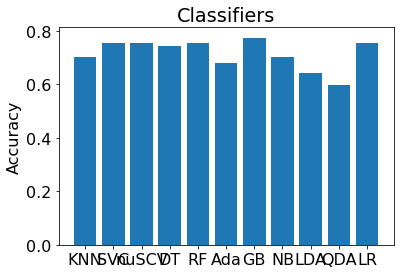

In [ ]:
import matplotlib.pyplot as plt
classifier=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR']
y_pos = np.arange(len(classifier))
plt.bar(y_pos,np.array(accuracy))
plt.xticks(y_pos, classifier)
plt.ylabel('Accuracy')
plt.title('Classifiers')

# Principle Component Analysis

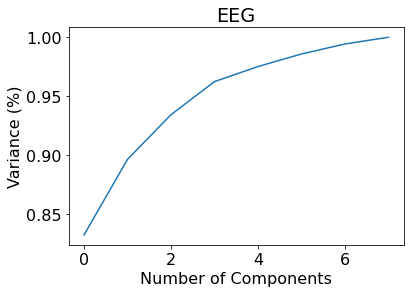

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('EEG')
plt.show()

In [ ]:
clf = SVC(kernel='rbf')
pca = PCA(n_components=5)

#pipeline = Pipeline([('selector',pca), ('estimator', clf)])
pipeline = Pipeline([('transformer', sc),('selector',pca), ('estimator', clf)])


In [ ]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_pca=[]
std_pca=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_pca.append(np.array(scores).mean())
    std_pca.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 69.0000%
SVC
****Results****
Accuracy: 74.2105%
NuSVC
****Results****
Accuracy: 74.3158%
DecisionTreeClassifier
****Results****
Accuracy: 72.1579%
RandomForestClassifier
****Results****
Accuracy: 79.4737%
AdaBoostClassifier
****Results****
Accuracy: 70.1053%
GradientBoostingClassifier
****Results****
Accuracy: 81.4737%
GaussianNB
****Results****
Accuracy: 76.3158%
LinearDiscriminantAnalysis
****Results****
Accuracy: 73.2632%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 77.3158%
LogisticRegression
****Results****
Accuracy: 72.2632%


In [ ]:
from sklearn.model_selection import GridSearchCV

clf = SVC(kernel="rbf")
n_components = [5,10,15,20]
Cs = [0.001,0.1, 1,2,3,5,7,10,15,30]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scalar',sc),('selector', pca), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(selector__n_components=n_components,
                              classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7842105263157896


{'classifier__C': 3, 'classifier__gamma': 0.01, 'selector__n_components': 20}

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = KNeighborsClassifier()
n_components = [5,10,15,20]
n_neighbors  = [ 3,4,5,6,7,8,9]
weights  = ['uniform','distance']
metric=['minkowski','manhattan','euclidean']
pipe = Pipeline(steps=[('scalar',sc),('selector', pca), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(selector__n_components=n_components,
                              classifier__n_neighbors=n_neighbors,classifier__weights=weights,classifier__metric=metric),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7942105263157895


{'classifier__metric': 'manhattan',
 'classifier__n_neighbors': 4,
 'classifier__weights': 'distance',
 'selector__n_components': 10}

# RFE

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:

clf = SVC(kernel='rbf')
rfe=RFE(SVC(kernel='linear'),n_features_to_select=5,step=1,verbose=0)   

#pipeline = Pipeline([('selector',rfe), ('estimator', clf)])
pipeline = Pipeline([('transformer', sc),('selector',rfe), ('estimator', clf)])


In [ ]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_rfe=[]
std_rfe=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_rfe.append(np.array(scores).mean())
    std_rfe.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 78.4211%
SVC
****Results****
Accuracy: 81.4211%
NuSVC
****Results****
Accuracy: 74.0000%
DecisionTreeClassifier
****Results****
Accuracy: 80.3158%
RandomForestClassifier
****Results****
Accuracy: 81.5789%
AdaBoostClassifier
****Results****
Accuracy: 76.2105%
GradientBoostingClassifier
****Results****
Accuracy: 79.3158%
GaussianNB
****Results****
Accuracy: 70.1053%
LinearDiscriminantAnalysis
****Results****
Accuracy: 79.3684%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 67.1579%
LogisticRegression
****Results****
Accuracy: 79.3684%


# SKbest

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [ ]:

clf = SVC(kernel='rbf')
skbest=SelectKBest(f_classif, k=10)
#pipeline = Pipeline([('selector',skbest), ('estimator', clf)])
pipeline = Pipeline([('transformer', sc),('selector',rfe), ('estimator', clf)])


In [ ]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_kbest=[]
std_kbest=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_kbest.append(np.array(scores).mean())
    std_kbest.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 78.4211%
SVC
****Results****
Accuracy: 81.4211%
NuSVC
****Results****
Accuracy: 74.0000%
DecisionTreeClassifier
****Results****
Accuracy: 77.3158%
RandomForestClassifier
****Results****
Accuracy: 78.4211%
AdaBoostClassifier
****Results****
Accuracy: 76.2105%
GradientBoostingClassifier
****Results****
Accuracy: 78.2632%
GaussianNB
****Results****
Accuracy: 70.1053%
LinearDiscriminantAnalysis
****Results****
Accuracy: 79.3684%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 67.1579%
LogisticRegression
****Results****
Accuracy: 79.3684%


# VarianceThreshold

In [ ]:
from sklearn.feature_selection import VarianceThreshold
clf = SVC(kernel='rbf')
selector = VarianceThreshold(0.05)
#pipeline = Pipeline([('selector',algo), ('estimator', clf)])
pipeline = Pipeline([('transformer', sc),('selector',selector), ('estimator', clf)])


In [ ]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_var=[]
std_var=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_var.append(np.array(scores).mean())
    std_var.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 70.1053%
SVC
****Results****
Accuracy: 75.2632%
NuSVC
****Results****
Accuracy: 75.2632%
DecisionTreeClassifier
****Results****
Accuracy: 72.2105%
RandomForestClassifier
****Results****
Accuracy: 72.2105%
AdaBoostClassifier
****Results****
Accuracy: 68.0526%
GradientBoostingClassifier
****Results****
Accuracy: 75.3684%
GaussianNB
****Results****
Accuracy: 70.1053%
LinearDiscriminantAnalysis
****Results****
Accuracy: 64.0526%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 59.8421%
LogisticRegression
****Results****
Accuracy: 75.3158%


# Result

In [ ]:
len(accuracy),len(accuracy_pca),len(accuracy_rfe),len(accuracy_kbest),len(accuracy_var)

(11, 11, 11, 11, 11)

In [ ]:
result=pd.DataFrame([accuracy,accuracy_pca,accuracy_rfe,accuracy_kbest,accuracy_var],
                    index=['Accuracy','PCA',"RFE",'kbest','VAR'],
                    columns=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR'])

In [ ]:
result=result.T

In [ ]:

def _color_red_or_green(val):
    color = 'red' if val < 0.7 else 'green'
    return 'color: %s' % color
result.style.applymap(_color_red_or_green)

In [ ]:
#Higest accuracy 90% check PCA section or following code